In [1]:
import numpy as np
import tensorflow as tf
from image_utils import image_from_url
from lstm import MaxLikelihoodLSTM, PolicyGradientLSTM
from data import PGData, COCOData

In [2]:
def initialize_uninitialized(sess):
    ruv = set(sess.run(tf.report_uninitialized_variables()))
    uv = [v for v in tf.global_variables() if v.name.split(':')[0].encode('ascii') in ruv]
    tf.variables_initializer(uv).run()

In [3]:
data = COCOData()
pgdata = PGData()

In [4]:
lstm = MaxLikelihoodLSTM(tf.constant(data.word_embedding, dtype=tf.float32), learning_rate=5e-3, batch_size=100)
lstm.build_model()

sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

tf.reset_default_graph()
sess.close()

In [5]:
sess = tf.InteractiveSession()
lstm = PolicyGradientLSTM(tf.constant(pgdata.word_embedding, dtype=tf.float32), learning_rate=5e-4, batch_size=100)

lstm.load_model(sess, "models/mle500")
initialize_uninitialized(sess)

INFO:tensorflow:Restoring parameters from models/mle500


In [6]:
losses = []
actions = []
rewards = []
advantages = []
end_masks = []

In [8]:
for i in range(50):
    loss, action, reward, advantage = lstm.train(sess, pgdata)
    pgdata.shuffle()
    print(np.mean(loss), np.var(action), np.mean(reward), np.mean(advantage))
    print("------------")
    losses.extend(loss)
    actions.extend(action)
    rewards.extend(reward)
    advantages.extend(advantage)

{'image_id': '1681', 'caption': 'a <UNK> in a kitchen next to <UNK> with a <UNK> with <UNK> in a <UNK>'}
[{'caption': 'a sandwich with cheese and vegetables on a piece of plastic <END>'}, {'caption': 'a take out sandwich on a <UNK> <UNK> <END>'}, {'caption': 'a picture of a <UNK> sandwich with cheese and <UNK> <END>'}, {'caption': 'a sandwich with <UNK> and various other vegetables on top of a plastic bag <END>'}, {'caption': 'a close up of a sandwich in plastic <END>'}]
1.02985 11647.0913184 1.38443211014 0.740971285151
------------
{'image_id': '82178', 'caption': 'a <UNK> of a brown <UNK> of a brown chair <END>'}
[{'caption': 'fire hydrant has two <UNK> on it to <UNK> it a face <END>'}, {'caption': 'a fire hydrant with a face painted on the front in an open field <END>'}, {'caption': 'a fire hydrant is <UNK> at the bottom of a grassy hill <END>'}, {'caption': 'a grey fire hydrant with <UNK> eyes on it on grassy hill <END>'}, {'caption': 'a gray fire hydrant in the middle of an open 

0.672183 6692.28058594 1.41918448921 0.64209840138
------------
{'image_id': '8457', 'caption': 'a wooden corner of a motorcycle <UNK> a <UNK> <END>'}
[{'caption': 'three people are on a sidewalk with a fire hydrant <END>'}, {'caption': '<UNK> guys and a girl are posing in front of a street sign <END>'}, {'caption': 'people are posing by a fire hydrant and a stop light <END>'}, {'caption': 'three people posing for a picture with a street sign and a fire hydrant <END>'}, {'caption': 'the three friends are posing for a photo next to the fire hydrant <END>'}]
0.677008 4500.83104844 1.46426530638 0.627937002316
------------
{'image_id': '49306', 'caption': 'a group of <UNK> <UNK> over a <UNK> of a building for a <UNK> <END>'}
[{'caption': 'people and their motor <UNK> waiting on a city corner <END>'}, {'caption': 'four people are on the street corner two are using cell phones <END>'}, {'caption': 'four people are standing on the sidewalk waiting for the bus <END>'}, {'caption': 'two women 

0.600187 2594.77062344 1.49171339754 0.741292311337
------------
{'image_id': '17451', 'caption': 'a <UNK> with a person standing in a <UNK> on a couch <END>'}
[{'caption': 'a group of adults at an asian fruit market <END>'}, {'caption': 'a fruit market outdoors with about five women <UNK> it <END>'}, {'caption': 'a number of fruits on plastic containers <END>'}, {'caption': 'several people shop around an outdoor vegetable market <END>'}, {'caption': 'there is <UNK> of fresh fruit being <UNK> at the market <END>'}]
0.625679 3757.02786094 1.45889568085 0.768431634318
------------
{'image_id': '32646', 'caption': 'a <UNK> on a <UNK> in a <UNK> <END>'}
[{'caption': 'a laptop computer sitting on a wooden table next to a mouse <END>'}, {'caption': 'apple computers <UNK> and <UNK> new <UNK> mouse <END>'}, {'caption': 'a white apple mouse in front of an apple laptop <END>'}, {'caption': 'a white mouse and a laptop on a tan table <END>'}, {'caption': 'a laptop computer sitting on a desk next t

In [20]:
np.mean(np.array(rewards)[:, -1])

NameError: name 'rewards' is not defined

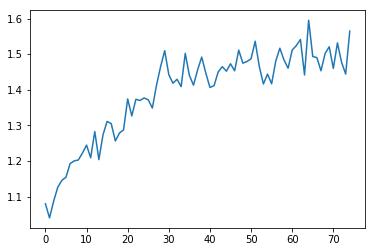

In [18]:
import matplotlib.pyplot as plt

rewards_arr = np.array(rewards)
plt.plot(np.mean(np.reshape(rewards_arr[:, -1], (75, 100)), axis=1))
# plt.plot(rewards_arr[:, -1])
plt.show()

In [21]:
rewards_arr[np.argmax(rewards_arr[:, -1]), -1]

3.6981398064121747

In [20]:
data.decode(actions[2844])

'a snowboarder <UNK> a <UNK> on a skateboard <UNK> a <UNK> <END>'

In [15]:
rewards[1]

array([-1.16937698,  0.46125179,  0.97043135,  0.16074349,  0.64402426,
        1.97278391,  1.97278391,  1.97278391,  1.97278391,  1.97278391,
        1.97278391,  1.97278391,  1.97278391,  1.97278391,  1.97278391,
        1.97278391])

In [7]:
tf.reset_default_graph()
sess.close()

In [21]:
from pyciderevalcap.eval import CIDErEvalCap as ciderEval
cand_list, ref = [], {}
for i in range(1000, 2000):
    idx = str(i)
    ref[idx]  = pgdata.data['train_image_idx_to_captions'][idx][0:-1]
    cand_list.append({'image_id': idx, 'caption': pgdata.data['train_image_idx_to_captions'][idx][-1]['caption']})

scorer = ciderEval(ref, cand_list, "coco-val-df")
scores = scorer.evaluate()

In [22]:
np.mean(scores)

1.7911916746177574

In [16]:
ref['113']

[{'caption': 'a motorcycle in front of a closed <UNK> door <END>'},
 {'caption': 'a motorcycle is parked in front of a <UNK> door <END>'},
 {'caption': 'a motorcycle parked next to a closed <UNK> <END>'},
 {'caption': 'a motorcycle is parked in front of a closed <UNK> area <END>'}]

In [17]:
cand_list[113]

{'caption': 'a motorcycle parked in front of a closed <UNK> door <END>',
 'image_id': '113'}

In [3]:
data = COCOData()
lstm = MaxLikelihoodLSTM(tf.constant(data.word_embedding, dtype=tf.float32), learning_rate=5e-3, batch_size=100)
lstm.build_model()

sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

lstm.train(sess, data, max_iterations=200)
lstm.save_model(sess, "mle200")

tf.reset_default_graph()
sess.close()

iter 0, cross-entropy: 110.77640533447266, accuracy: 0.0009033423848450184
iter 10, cross-entropy: 55.980995178222656, accuracy: 0.18133333325386047
iter 20, cross-entropy: 46.787872314453125, accuracy: 0.2949061691761017
iter 30, cross-entropy: 45.030513763427734, accuracy: 0.29328620433807373
iter 40, cross-entropy: 40.0538444519043, accuracy: 0.354092538356781
iter 50, cross-entropy: 38.95996856689453, accuracy: 0.34336283802986145
iter 60, cross-entropy: 38.451683044433594, accuracy: 0.3449508547782898
iter 70, cross-entropy: 37.561832427978516, accuracy: 0.3582887649536133
iter 80, cross-entropy: 36.59442901611328, accuracy: 0.3383658826351166
iter 90, cross-entropy: 36.408565521240234, accuracy: 0.36758193373680115
iter 100, cross-entropy: 35.531898498535156, accuracy: 0.35695067048072815
iter 110, cross-entropy: 35.716224670410156, accuracy: 0.3502262532711029
iter 120, cross-entropy: 32.944496154785156, accuracy: 0.4005400538444519
iter 130, cross-entropy: 33.486305236816406, a

In [4]:
sess = tf.InteractiveSession()
pgdata = PGData()
lstm = PolicyGradientLSTM(tf.constant(pgdata.word_embedding, dtype=tf.float32), learning_rate=5e-4, batch_size=100)

lstm.load_model(sess, "models/mle200")
initialize_uninitialized(sess)

INFO:tensorflow:Restoring parameters from models/mle200


In [5]:
losses = []
actions = []
rewards = []

In [6]:
for i in range(100):
    loss, action, reward = lstm.train(sess, pgdata)
    print(np.mean(loss), np.var(action), np.mean(reward))
    print("------------")
    losses.extend(loss)
    actions.extend(action)
    rewards.extend(reward)

6.79727 28352.2155859 6.75890224169
------------
15.7928 22696.4748734 7.39221483388
------------
5.79293 16492.4432184 8.34937176333
------------
6.64818 16106.3086734 8.52836480001
------------
10.2895 15566.1895484 9.03667793331
------------
9.1476 12645.6911937 8.89655516228
------------
6.73192 11071.8929438 9.25449530212
------------
6.51581 10926.21865 9.35947495779
------------
6.72046 7956.61590586 9.59848782547
------------
6.86378 5728.16919375 9.80387041364
------------
5.91337 4954.86419375 9.63229866935
------------
6.47509 5737.035475 9.68781971404
------------
5.60096 3612.71029844 10.1044931698
------------
5.22452 5332.271525 10.1027949668
------------
4.89143 3910.99374844 10.1628756767
------------
4.17895 2579.64617148 10.4191614825
------------
3.85186 1853.07724844 10.8305630783
------------
3.00431 1495.83183594 11.2801947157
------------
2.36547 747.84625 10.7852484209
------------
2.54489 473.339912109 10.7863259785
------------
2.06788 186.04169375 10.7332224

In [7]:
lstm.save_model(sess, "mle200-pg100")

tf.reset_default_graph()
sess.close()

In [8]:
sess = tf.InteractiveSession()
lstm = MaxLikelihoodLSTM(tf.constant(data.word_embedding, dtype=tf.float32), learning_rate=5e-5, batch_size=100)

lstm.load_model(sess, "models/mle200-pg100")
initialize_uninitialized(sess)

lstm.train(sess, data, max_iterations=50)
lstm.save_model(sess, "mle200-pg100-mle50")

tf.reset_default_graph()
sess.close()

INFO:tensorflow:Restoring parameters from models/mle200-pg100
iter 0, cross-entropy: 72.76022338867188, accuracy: 0.2719060480594635
iter 10, cross-entropy: 36.16719055175781, accuracy: 0.35466668009757996
iter 20, cross-entropy: 31.900407791137695, accuracy: 0.4057193994522095
iter 30, cross-entropy: 32.784263610839844, accuracy: 0.3816254436969757
iter 40, cross-entropy: 30.72756576538086, accuracy: 0.4012455642223358
iter 50, cross-entropy: 28.579267501831055, accuracy: 0.4292035400867462


In [9]:
sess = tf.InteractiveSession()
lstm = PolicyGradientLSTM(tf.constant(pgdata.word_embedding, dtype=tf.float32), learning_rate=5e-5, batch_size=100)

lstm.load_model(sess, "models/mle200-pg100-mle50", is_PG=True)
initialize_uninitialized(sess)

for i in range(100):
    loss, action, reward = lstm.train(sess, pgdata)
    print(np.mean(loss), np.var(action), np.mean(reward))
    print("------------")
    losses.extend(loss)
    actions.extend(action)
    rewards.extend(reward)

INFO:tensorflow:Restoring parameters from models/mle200-pg100-mle50
7.03608 23016.1248734 7.2811827082
------------
9.52236 19556.167959 7.49611853665
------------
5.88758 14137.2895465 8.6825888869
------------
7.75762 15079.3587359 8.239986209
------------
7.02797 13499.1203809 8.94010978427
------------
7.90079 9523.02499961 9.10653697902
------------
4.81611 7675.150775 9.30012921182
------------
6.79755 7063.00349844 9.29885271251
------------
5.45757 5078.94053086 9.45868507054
------------
5.78207 4956.10036094 9.69185834107
------------
4.8812 6607.63869961 9.98387956558
------------
4.97594 4915.17732461 10.2769814713
------------
6.25036 5029.36671836 10.185059677
------------
4.49798 4825.67473594 10.2924518771
------------
4.52176 2703.51272461 10.1263248866
------------
3.642 1605.23756836 10.1786381274
------------
3.31048 2945.88559336 10.307262836
------------
2.90374 1005.40795898 10.8312000334
------------
2.58809 904.447233984 10.2746556744
------------
2.72039 328.3

In [13]:
data.decode(actions[19605])

'a <UNK> <END>'

In [5]:
tf.reset_default_graph()
sess.close()

In [2]:
data = PGData()
lstm = MaxLikelihoodLSTM(tf.constant(data.word_embedding, dtype=tf.float32), learning_rate=5e-3, batch_size=100)
lstm.build_model()

sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

tf.reset_default_graph()
sess.close()

In [22]:
tf.reset_default_graph()
sess.close()# data = PGData()
lstm = PolicyGradientLSTM(tf.constant(data.word_embedding, dtype=tf.float32), learning_rate=5e-4, batch_size=100)

sess = tf.InteractiveSession()

lstm.load_model(sess, "models/200iter")
lstm.build_model(loaded=True)

ruv = set(sess.run(tf.report_uninitialized_variables()))
uv = [v for v in tf.global_variables() if v.name.split(':')[0].encode('ascii') in ruv]
tf.variables_initializer(uv).run()

INFO:tensorflow:Restoring parameters from models/200iter


In [ ]:
losses = []
actions = []
rewards = []

In [53]:
for i in range(60):
    loss, action, reward = lstm.train(sess, data)
    print(np.mean(loss), np.var(action), np.mean(reward))
    print("------------")
    losses.extend(loss)
    actions.extend(action)
    rewards.extend(reward)

0.350779 43.4011558594 12.9776906824
------------
0.424632 69.0095152344 12.9335559227
------------
0.754854 77.05299375 12.9692724324
------------
0.410619 120.84899375 13.0360450496
------------
0.488262 82.7475609375 12.9830271097
------------
0.550675 90.5807714844 12.8107597708
------------
0.515419 121.396298438 12.8699514147
------------
0.526229 104.748173438 12.8825245009
------------
0.477347 92.516225 13.106982613
------------
0.404463 99.3007777344 13.2391322928
------------
0.713771 145.291262109 12.9443670165
------------
0.621591 105.11234375 13.2622064675
------------
0.508496 115.928349609 13.1550630019
------------
0.499779 90.2325308594 13.3426446317
------------
0.491567 117.826552734 13.2545859293
------------
0.386018 88.1824359375 13.3093267378
------------
0.379715 103.435218359 13.2560856038
------------
0.586515 100.572775 13.3206869848
------------
0.300589 108.7325 13.2287536794
------------
0.486376 102.976793359 13.1132305169
------------
0.506196 114.7604

In [58]:
data.decode(actions[19692])

'a <UNK> on a laptop <END>'

In [59]:
lstm.save_model(sess, "200iter-pg")

In [67]:
np_losses = np.array(losses)
np_rewards = np.array(rewards)

In [69]:
smoothed_reward = np.mean(np.reshape(np.mean(np_rewards, axis=1), (200, 100)), axis=1)

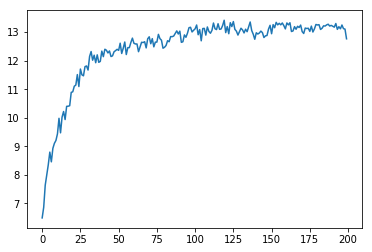

In [70]:
import matplotlib.pyplot as plt

plt.plot(smoothed_reward)
plt.show()

In [10]:
data.decode(actions[100])

'umpire others others others others others others others others others others others others others others others'

In [4]:
losses = []
actions = []
rewards = []
for i in range(20):
    loss, action, reward = lstm.train(sess, data)
    print(np.mean(loss), np.mean(action), np.mean(reward))
    print("------------")
    losses.extend(loss)
    actions.extend(actions)
    rewards.extend(rewards)

-12.82 69.5625 6.87304330802
------------
6.39723 4.2075 8.9351062407
------------
-76.2855 3.861875 9.13000743446
------------
0.838973 3.12 6.38925638628
------------
0.668457 3.14125 6.67301378924
------------
0.232755 3.186875 7.17962908384
------------
0.248688 3.225625 7.59940262319
------------
0.382631 3.241875 7.71845283215
------------
0.539777 3.3175 8.30026896657
------------
0.334065 3.250625 7.81346836181
------------
0.456811 3.26625 7.93577438762
------------
0.288374 3.253125 7.879862125
------------
0.309026 3.265 8.00462726839
------------
0.386012 3.234375 7.70541213859
------------
0.31305 3.248125 7.84436545403
------------
0.345958 3.236875 7.68190799535
------------
0.413872 3.240625 7.81636161124
------------
0.300608 3.23375 7.68419020213
------------
0.259563 3.245625 7.85480033378
------------
0.254374 3.244375 7.82044134311
------------


In [82]:
tf.reset_default_graph()
sess.close()

data = COCOData()
lstm = MaxLikelihoodLSTM(tf.constant(data.word_embedding, dtype=tf.float32), learning_rate=5e-6, batch_size=100)
# lstm.build_model()

sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

lstm.load_model(sess, "models/200iter-pg")
lstm.train(sess, data, max_iterations=300)
lstm.save_model(sess, "reheated")

INFO:tensorflow:Restoring parameters from models/200iter-pg
iter 0, cross-entropy: 70.06298828125, accuracy: 0.27182719111442566
iter 10, cross-entropy: 33.243900299072266, accuracy: 0.36804309487342834
iter 20, cross-entropy: 29.137388229370117, accuracy: 0.4158325791358948
iter 30, cross-entropy: 28.673114776611328, accuracy: 0.42959001660346985
iter 40, cross-entropy: 27.863300323486328, accuracy: 0.42724746465682983
iter 50, cross-entropy: 29.713666915893555, accuracy: 0.4148082137107849
iter 60, cross-entropy: 26.70343017578125, accuracy: 0.44485634565353394
iter 70, cross-entropy: 27.00839614868164, accuracy: 0.4376731216907501
iter 80, cross-entropy: 28.623607635498047, accuracy: 0.434628963470459
iter 90, cross-entropy: 28.676406860351562, accuracy: 0.41952982544898987
iter 100, cross-entropy: 28.153303146362305, accuracy: 0.4374445378780365
iter 110, cross-entropy: 28.017078399658203, accuracy: 0.4295964241027832
iter 120, cross-entropy: 27.698930740356445, accuracy: 0.4413102

In [2]:
data = PGData()
lstm = MaxLikelihoodLSTM(tf.constant(data.word_embedding, dtype=tf.float32), learning_rate=5e-3, batch_size=100)
lstm.build_model()

sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

In [3]:
tf.reset_default_graph()
sess.close()

lstm = PolicyGradientLSTM(tf.constant(data.word_embedding, dtype=tf.float32), learning_rate=5e-5, batch_size=100)

sess = tf.InteractiveSession()

lstm.load_model(sess, "models/reheated", True)
# lstm.build_model(loaded=True)

ruv = set(sess.run(tf.report_uninitialized_variables()))
uv = [v for v in tf.global_variables() if v.name.split(':')[0].encode('ascii') in ruv]
tf.variables_initializer(uv).run()

INFO:tensorflow:Restoring parameters from models/reheated


KeyError: "The name 'PG/sampled_ac:0' refers to a Tensor which does not exist. The operation, 'PG/sampled_ac', does not exist in the graph."

In [4]:
graph = tf.get_default_graph()
graph.get_tensor_by_name("sampled_ac:0")

KeyError: "The name 'sampled_ac:0' refers to a Tensor which does not exist. The operation, 'sampled_ac', does not exist in the graph."

In [5]:
tf.global_variables()

[<tf.Variable 'image_proj/kernel:0' shape=(4096, 512) dtype=float32_ref>,
 <tf.Variable 'image_proj/bias:0' shape=(512,) dtype=float32_ref>,
 <tf.Variable 'embedding:0' shape=(1004, 304) dtype=float32_ref>,
 <tf.Variable 'rnn/lstm_cell/kernel:0' shape=(816, 2048) dtype=float32_ref>,
 <tf.Variable 'rnn/lstm_cell/bias:0' shape=(2048,) dtype=float32_ref>,
 <tf.Variable 'logits/kernel:0' shape=(512, 1004) dtype=float32_ref>,
 <tf.Variable 'logits/bias:0' shape=(1004,) dtype=float32_ref>,
 <tf.Variable 'beta1_power:0' shape=() dtype=float32_ref>,
 <tf.Variable 'beta2_power:0' shape=() dtype=float32_ref>,
 <tf.Variable 'image_proj/kernel/Adam:0' shape=(4096, 512) dtype=float32_ref>,
 <tf.Variable 'image_proj/kernel/Adam_1:0' shape=(4096, 512) dtype=float32_ref>,
 <tf.Variable 'image_proj/bias/Adam:0' shape=(512,) dtype=float32_ref>,
 <tf.Variable 'image_proj/bias/Adam_1:0' shape=(512,) dtype=float32_ref>,
 <tf.Variable 'embedding/Adam:0' shape=(1004, 304) dtype=float32_ref>,
 <tf.Variable 'e

In [85]:
losses_reheated = []
actions_reheated = []
rewards_reheated = []

In [86]:
for i in range(60):
    loss, action, reward = lstm.train(sess, data)
    print(np.mean(loss), np.var(action), np.mean(reward))
    print("------------")
    losses_reheated.extend(loss)
    actions_reheated.extend(action)
    rewards_reheated.extend(reward)

AttributeError: 'PolicyGradientLSTM' object has no attribute 'sampled_ac'